# Assignment 01 - Hash Tables and Pitfalls in Data Mining     
## CSCI E-108

The goal of data mining is to find important relationships in large complex datasets. These datasets typically contain a large number of variables. The **high-dimensional** nature of the data leads to some commonly encountered pitfalls which lead to incorrect inferences.   

In this assignment you will gain a bit of experience with two important concepts in data mining using a small scale example. These methods are essential as the scale increases:  
1. **False Discovery Rate Control:** The goal of data mining is to find important relationships in large complex datasets. These datasets typically contain a large number of variables. The **high-dimensional** nature of the data leads to a commonly encountered pitfall of incorrect inference, **false discovery**. A related problem is when a large-scale analysis is terminated when a desired relationship is 'found'. This practice of **p-value mining** often leads to unwarranted inferences. In the exercises in this notebook you will apply **false discovery rate (FDR) control** methods to address these problems.   
2. **Hashing and Key-Value Pairs:** Large scale data is typically managed using key-value (KV) pairs in hash tables. The exercises in this assignment give you some experience working with KV pair data management in a hash table.  

In order to keep the scope of this assignment manageable, you will use limited versions of KV pair management on a hash table. Specifically, you will use a simple Python list implement these concepts rather than dedicated large scale analytic platforms. 

To get started, execute the code in the cell below to load the required packages. 

In [39]:
import pandas as pd
import numpy as np
import numpy.random as nr
from scipy.stats import ttest_ind, f_oneway
from itertools import product, combinations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
import math
import time
import sys

pd.set_option("display.max_rows", None, "display.max_columns", None)

## Synthetic Data for Multiple Hypothesis Testing

Testing multiple hypothesis in high-dimensional data is problematic. Exhaustively testing all pairwise relationships between variables in a data set is a commonly used, but generally misleading, form of **multiple comparisons**. The chance of finding false significance, using such a **data dredging** approach, can be surprisingly high. 

In the following exercises you will perform multiple comparisons on **20 identically distributed independent (iid)** variables. Ideally, such tests should not find significant relationships, but the actual result is quite different. Here we create a synthetic data set with 20 iid Normal variables of 1000 samples each. Execute the code in the cell below to compute this data by random sampling and display the mean and variance of each variable and the correlation between them.  

The means of the variables are
 [-0.00021802 -0.02469621 -0.04590329 -0.03378607  0.04803816 -0.0483221
  0.00823324  0.07504879 -0.02464511  0.02506955  0.01587333 -0.02779571
  0.0283405  -0.007355   -0.01933494  0.04458928 -0.04394166  0.04176807
  0.04012348  0.03759568]

The variances of the variables are
 [0.99858704 1.1399064  0.99541705 1.03581236 0.99903254 0.98047187
 0.9430031  1.0229532  1.04648727 0.97117199 0.91340712 0.96426648
 1.06103587 0.98162457 1.01358424 1.05532882 0.99885087 0.92218934
 0.96236408 1.04297434]


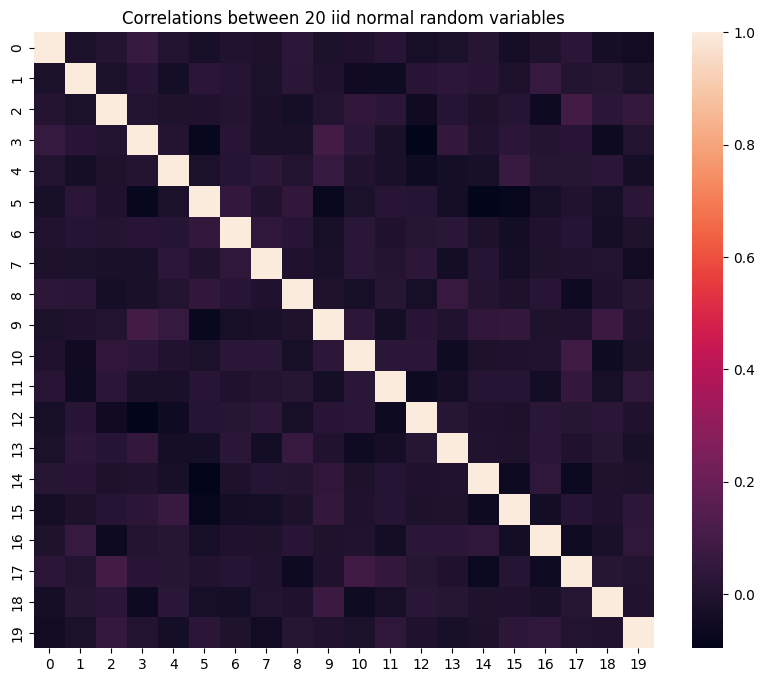

In [40]:
ncolumns = 20
nr.seed(22349)
normal_vars = nr.normal(size=(1000,ncolumns))
print('The means of the variables are\n', np.mean(normal_vars, axis = 0))
print('\nThe variances of the variables are\n', np.var(normal_vars, axis = 0))

_, ax = plt.subplots(figsize=(10,8))
sns.heatmap(np.corrcoef(np.transpose(normal_vars)), ax=ax);
ax.set_title('Correlations between 20 iid normal random variables');

Notice that means are close to 0.0 and variances are close to 1.0 respectively.    



## Hash Functions and Hash Tables  

Management of massive datasets requires using **key-value pairs** in a **hash table**. The keys are hashed and the hashes used as indices to reference buckets in the hash table. The buckets hold a tuple of the original key (unhashed) and the values.   
 
The question is, how can we create a good hash function for the the keys? Ideally, the hash function should produce keys with these closely related properties:   
1. The hash values should be unique given the keys to avoid hash collisions.
2. The hash values should be uniformly distributed given the keys. 

### Universal hash functions
**[Universal hash functions](https://en.wikipedia.org/wiki/Universal_hashing)** are fairly simple to implement and yet have generally good properties. Consider hashing a set of integers, $U = [i_1, i_2, i_3,..., u_u]$. We want to create a family of hash functions, $H(U) \rightarrow m$, to map $U$ to $m$ unique hash values. Ideally, we want the the probability of a hash value to be uniform, $p \big(h(i) \big) \le \frac{1}{m}$.    

For the integer keys, we will work work with a universal hash function in the form:     

$$h(i) = \big( (a\ i + b)\ mod\ p \big)\ mod\ m$$
where   
- a is a random multiplier, $0 \lt a \lt p -1$ and $a \ne 0$.
- b is a random additive factor, .   
- p is a (usually prime) number, $p \ge |U|$, $|U| = $ size for the set to be hashed.
- m is the size of the hash table.

In this case, we will be working with a vector of keys of length 2, $K=[k_1,k_2]$. The universal hash of an $n$ length vector of values can easily be computed:    

$$h(K) = \Big( \sum^n_{i=1} h_i (k_i) \Big)\ mod\ m$$
Where, each of the $h_1, h_2, ..., h_n$ are independent universal hash functions.   

> **Exercise 1-01:** In this notebook you will perform pairwise hypothesis tests on sets of vector-valued variables. There are $\frac{n (n-1)}{2}$ pairwise combinations. There are two keys, $[i,j]$, for this hash table.
> 
> We could simply manage the results set in a Pandas data frame and do not need a sophisticated and scaleable hash table. To fulfill one of the goals of these exercises, we will use a hash table with vector-valued keys.     
>
> In this exercise you will test a universal hash function using vector-valued keys. To complete the code and test this hash, do the following:    
> 1. Complete `hash_function` in the code cell below to implement the integer key universal hash function discussed the foregoing section. The function should return an integer hash in the range $[1,1024]$ given an integer key value. 
> 2. Complete the code that iterates over all combinations of the keys (indexes) of the 20 variables and displays the keys and hash values.
>    - Use the itertools package [combinations](https://docs.python.org/3/library/itertools.html#itertools.combinations) function to find all combinations of two keys in `range(ncolumns)`.
>    - For each combination of keys, $i, j$, find the hash value using the `multivariate_hash` function provided.
>    - Append the keys and hash value to `hash_list`.
> Execute your code and examine the results. 

In [41]:
modulo=1024
a_s=[10147, 34519]
b_s=[2341, 7575]
p_s=[101273, 106949]   

def hash_function(key, a, b, p, modulo):
    """
    Function to compute hash for hash of x 

    Args: 
        x - integer value to be hashed 
        a - random multiplier value
        b - random addition value 
        p - random modulo value
        modulo - an integer = length of the hash table 

    Returns: a integer hash value     
    """
    ## Complete the code in this function 
    return ((a * key + b) % p) % modulo
    

def multivariate_hash(x, a, b, p, modulo): 
    """
    Function to compute hash for hash a vector x 

    Args: 
        x - vector or list of integer values 
        a - random vector of multiplier values of len(x)
        b - random vector of addition values of len(x) 
        p - random vector of modulo values of len(x) 
        modulo - an integer = length of the hash table 

    Returns: a integer hash value     
    """
    h = []
    for i, key in enumerate(x):
        h.append(hash_function(key, a[i], b[i], p[i], modulo))
    return sum(h) % modulo


hash_list = []
## Put your code below
for i,j in combinations(range(ncolumns), 2):
    hash_value = multivariate_hash([i,j], a_s, b_s, p_s, modulo)
    hash_list.append(hash_value)

    ## Print a sample of the hash values 
    if i <= 3:             
        print('i = ' + str(i) + '  j = ' + str(j) + '   hash = ' + str(hash_value))
#    return(hash_list)        
#hash_list = print_hashes(a=a_s, b=b_s, p=p_s, modulo=modulo)            

i = 0  j = 1   hash = 403
i = 0  j = 2   hash = 106
i = 0  j = 3   hash = 380
i = 0  j = 4   hash = 83
i = 0  j = 5   hash = 810
i = 0  j = 6   hash = 60
i = 0  j = 7   hash = 787
i = 0  j = 8   hash = 490
i = 0  j = 9   hash = 193
i = 0  j = 10   hash = 467
i = 0  j = 11   hash = 170
i = 0  j = 12   hash = 897
i = 0  j = 13   hash = 147
i = 0  j = 14   hash = 874
i = 0  j = 15   hash = 577
i = 0  j = 16   hash = 851
i = 0  j = 17   hash = 554
i = 0  j = 18   hash = 257
i = 0  j = 19   hash = 531
i = 1  j = 2   hash = 13
i = 1  j = 3   hash = 287
i = 1  j = 4   hash = 1014
i = 1  j = 5   hash = 717
i = 1  j = 6   hash = 991
i = 1  j = 7   hash = 694
i = 1  j = 8   hash = 397
i = 1  j = 9   hash = 100
i = 1  j = 10   hash = 374
i = 1  j = 11   hash = 77
i = 1  j = 12   hash = 804
i = 1  j = 13   hash = 54
i = 1  j = 14   hash = 781
i = 1  j = 15   hash = 484
i = 1  j = 16   hash = 758
i = 1  j = 17   hash = 461
i = 1  j = 18   hash = 164
i = 1  j = 19   hash = 438
i = 2  j = 3   hash = 

> 3. The next question is how good is this hash function. We can run a simple test by plotting the hash values computed. Execute the code in the cell below to display a histogram and a cumulative distribution plot of the hash values. 

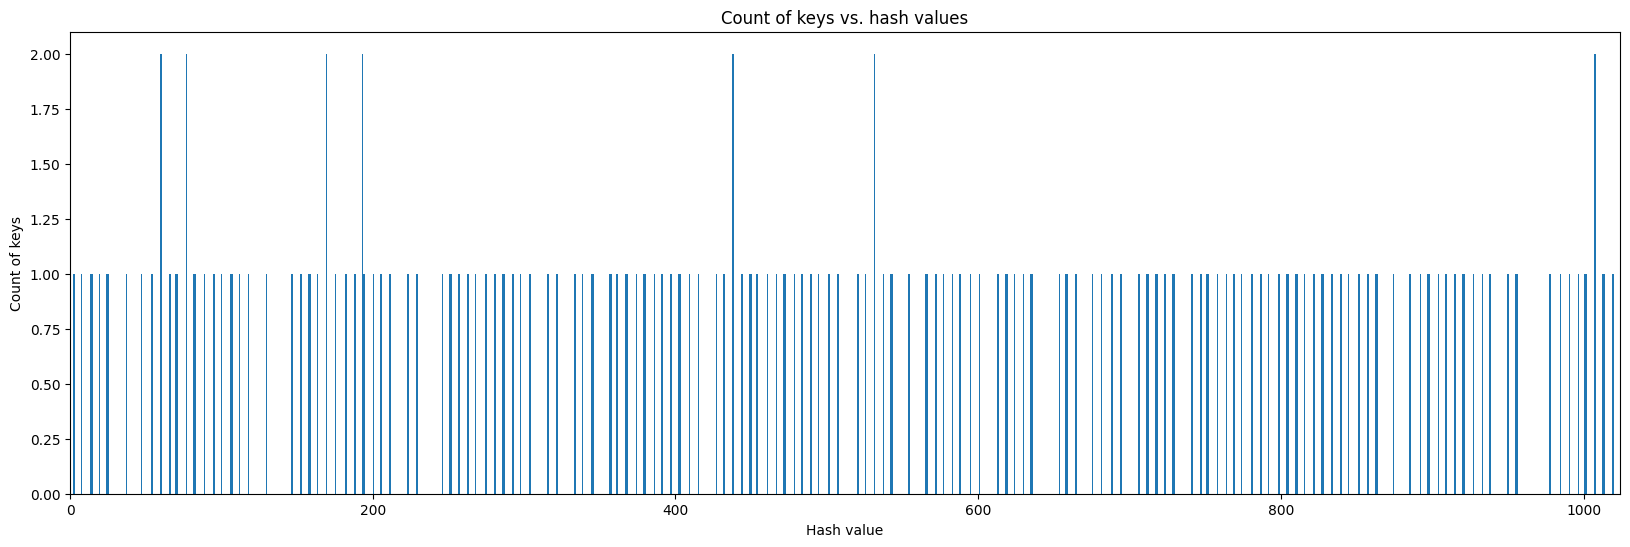

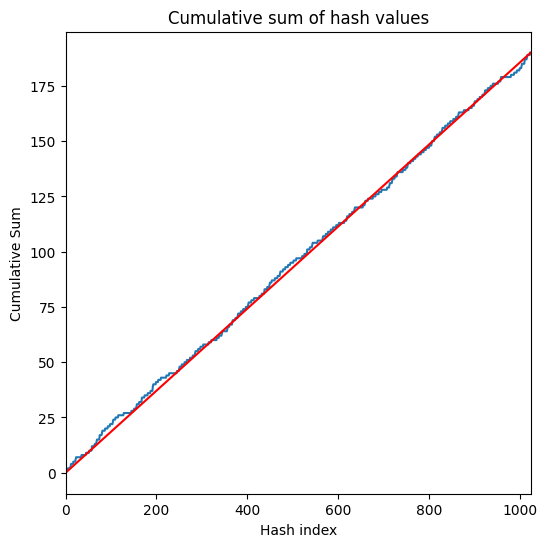

In [42]:
def plot_hash(hashes, bins=1024, modulo=1024):
    fig, ax = plt.subplots(figsize=(20, 6))
    counts, bins, _ = ax.hist(hashes, bins=bins);
    ax.set_ylabel('Count of keys');
    ax.set_xlabel('Hash value');
    ax.set_title('Count of keys vs. hash values');
    ax.set_xlim(0.0, modulo)
    plt.show();

    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(range(len(counts)), np.cumsum(counts))
    ax.plot([0.0,len(counts)], [0.0,len(hashes)], color='red');
    ax.set_ylabel('Cumulative Sum');
    ax.set_xlabel('Hash index');
    ax.set_title('Cumulative sum of hash values');
    ax.set_xlim(0.0, modulo)
    plt.show();
    
plot_hash(hash_list)  

> Examine these results and answer the following questions in one or two sentence.
> 1. Are hash collisions evident?     
> 2. Based on the histogram and cumulative distribution plot does this hash function have nearly ideal behavior, and what deviations can you observe?
> 3. Hypothetically, we could reduce the number of hash collisions by using a longer hash table. For massive scale problems why is this approach not practical?  
> **End of exercise.**

> **Answers:**    
> 1. Yes, there are hash collisions evident, as the first plot shows hash values with more than 1 key, meaning there are multiple keys with the same hash value.       
> 2. Yes, the distribution plot indicates the hash function closely resembles ideal behavior, with minor deviations from the perfectly uniform distribution (red line). These deviations include uneven bucket utilization (there are many empty buckets, seen from the regions where the blue line falls below the red line), some clustering of keys in certain regions (around the 100-250 range for example, where the blue line is above the red line), and some hash collissions (with a couple of buckets having more than one key). However, this deviations are minor, and can be easily solved using linear probing. 
> 3. For masive scale applications, a longer hash table would require exponentially more memory, which wouldn't likely fit in RAM and require disk storage, making it much slower to access. Besides, even though the number of hash collisions can be reduced, they can't be eliminated, meaning we would still need to find methods around those collisions. There may be additional problems: a single massive hash table doesn't scale well in distributed systems, so it can become a bottleneck in large scale applications. In the end, it is better to find a way to handle a few collisions rather than massively increasing the hash table size.         

### Linear probing        

Given the inevitable hash collisions we need a method to resolve them. **[Linear probing](https://en.wikipedia.org/wiki/Linear_probing)** is an effective, efficient and widely used hash collision resolution algorithm. The basic ideas is simple. If a hash bucket is occupied the algorithm linearly scans the table until an open bucket is found. The keys in each bucket are then used for look-ups.   

> **Exercise 1-02:** You will now compute the two missing lines of code to implement a simple linear probing algorithm. The algorithm operates as follows:
> 1. The bucket of the hashed key value is tested to see if it is empty. **Complete the code required for this case to add the key-value tuple to the table.**
> 2. If the first bucket is used, the linear probing starts with a while statement. The loop continues until an empty bucket is found or no empty bucket is available.
> 3. The hash value is incremented by 1.
> 4. If the new hash value is greater than the table length the hash value is set to 0, the beginning of the table. If the flag showing the table has started from the beginning already, the function returns `None` since there are no open hash buckets. Otherwise, the flag is set to 1 and probing for an open bucket continues.
> 5. **Complete the code to add the key-value tuple to the table for the case when an open buck in found in the linear search.**
>    
> Execute your code and examine the results.  

In [43]:
def instantiate_hash(length):  
    """
    function instantiates a hash table of lenght 'length'
    """
    return [None]*length
   

def linear_probing_insert(hash_value, kv_pair, hash_table):   
    """
    Function to insert key-value pairs into an existing hash table 

    Args
        hash_value - the hash index, int
        kv_pair - the k-v pair to inser4t as tuple, (key, value)
        hash_table - in the rofm of Python list    

    Returns: hash_table
    """
    if hash_table[hash_value] is None: 
        ## Complete the code below
        hash_table[hash_value] = kv_pair
         
    else: 
        hash_len = len(hash_table)
        flag = 0
        while hash_table[hash_value] is not None:
            hash_value += 1 # Increment the hash_value to prob of open bucket 
            if hash_value > hash_len - 1: # Don't want to run off end of table
                if flag == 1: # If we have been here before the table must be full  
                    print('No open buckets found')
                    return None 
                # wrap around to the beginning of the table to continue search 
                hash_value = 0   
                flag = 1
            if hash_table[hash_value] is None: 
                ## Complete the code below
                hash_table[hash_value] = kv_pair
                
                break
    return hash_table

hash_table = instantiate_hash(modulo)
for i,j in combinations(range(ncolumns), 2):
        hash_value = multivariate_hash([i,j], a_s, b_s, p_s, modulo)
        linear_probing_insert(hash_value, ((i,j), None), hash_table)

print('Sample of hash buckets')
print(hash_table[:50])
full_buckets = [0 if t is None else 1 for t in hash_table]
print(f"\nNumber of non-empty buckets: {sum(full_buckets)}")

Sample of hash buckets
[None, None, ((5, 10), None), None, None, None, None, ((2, 9), None), None, None, None, None, None, ((1, 2), None), ((9, 16), None), None, None, None, None, ((6, 15), None), None, None, None, None, ((10, 16), None), ((5, 8), None), None, None, None, None, None, None, None, None, None, None, None, ((9, 14), None), None, None, None, None, None, None, None, None, None, ((10, 14), None), None, None]

Number of non-empty buckets: 190


Now we can see that each of our pairwise combinations is mapped to exactly one bucket, as there are 190 non-empty buckets in our hash table!

> Next execute the code to display an histogram and cumulative distribution plot of the hash values once linear probing has been applied.    

The number of buckets: 190


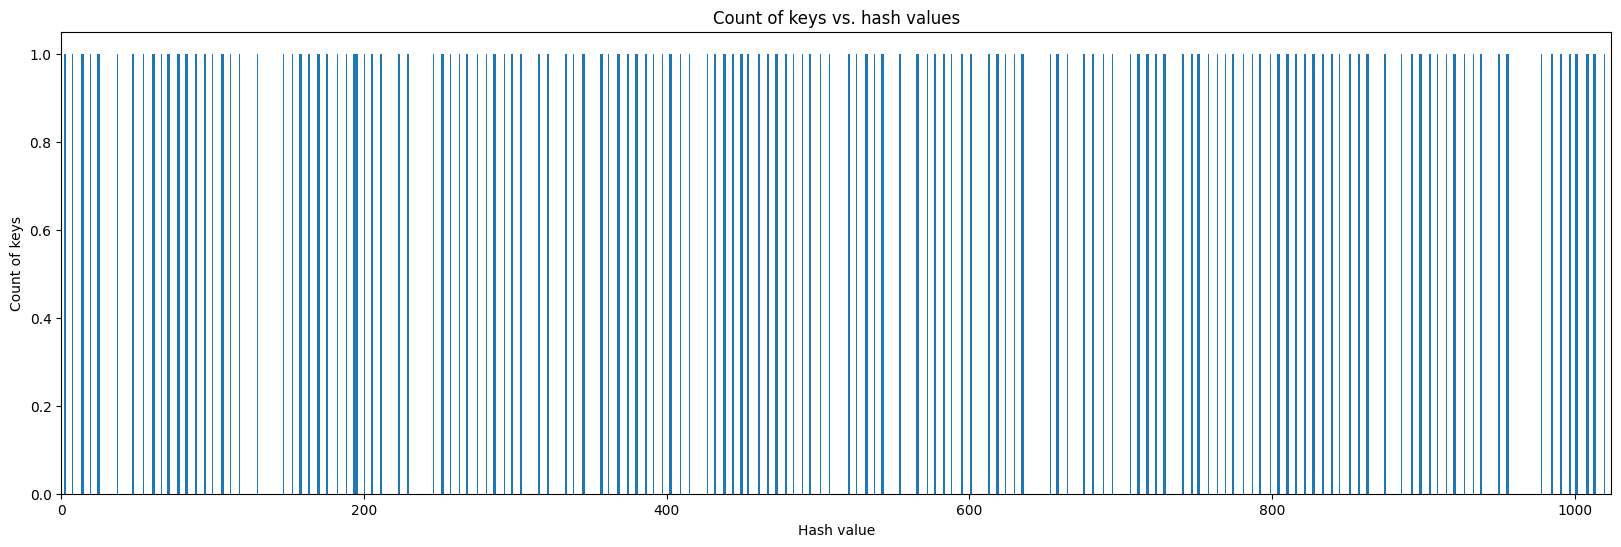

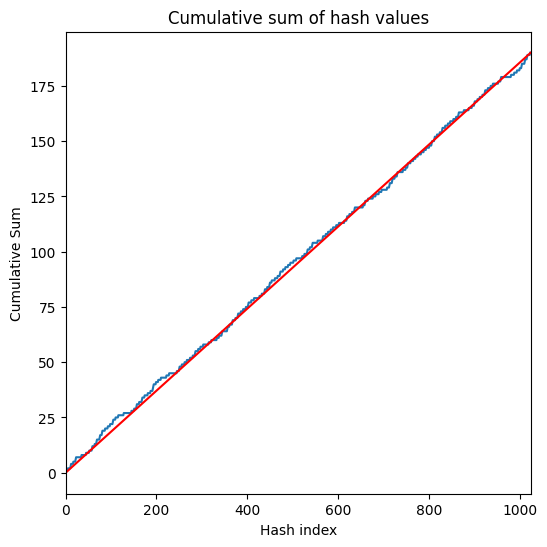

In [44]:
ls = []
for idx in range(len(hash_table)):
    if hash_table[idx] is not None: ls.append(idx) 

print(f"The number of buckets: {len(ls)}")
plot_hash(ls) 

> Examine these results and answer these questions:      
> 1. What evidence do you see that the hash collisions been resolved by the linear probing.
> 2. Has application of linear probing significantly affected the cumulative distribution function.         
> **End of exercise.**  

> **Answers:**    
> 1. In the Count of keys vs. Hash values plot we can observe there is a maximum of 1 key per hash value (it was 2 keys per hash value for some of the buckets before the linear probing), indicating that the linear probing method fixed the hash collisions.        
> 2. Not at all, the Cumulative distribution is almost identical, meaning the linear probing worked as expected. What we did was essentially placing a key in the next available bucket whenever there was a collision, meaning the total count of keys placed up to any position remains the same. 

## Adding Values to the Hash Buckets    

Now that hashing with linear probing has been implemented and a hash table instantiated with the keys, it is time to add the values to the table. At this point, the hash table only contains the keys, but no values. Specifically, you will add a tuple of the t-statistic and p-value for each of the k-v pairs already in the table. Recalling that the key has two values, you need to iterate over all the combinations of the random variable vectors (columns) to compute the pairwise statistics. The tuple of the keys and the tuple of the t-statistic and p-value update the contents of the hash bucket. The table now has complete k-v pairs for every combination of the variables being tested.         

There are two parts to the required processing. First, a function to update a bucket in the hash table given the linear probing is required. Second, you will need to compute the t-statistic and p-value and update the value of the appropriate bucket using the update function.

The `linear_prob_update` function follows a a pattern similar to the `linear_probing_insert` function you have already worked with. The flow of the function is as follows:
1. The bucket for the hashed key value is tested to see if the key is in that bucket. If so, the update is placed in the bucket. 
2. If the first bucket does not contain the required key, the linear probing starts with a while statement. The loop continues until the key is found, or it is determined that the key is not present in the table.
3. The hash value is incremented by 1.
4. If the new hash value is greater than the table length the hash value is set to 0, the beginning of the table. If the flag showing the table has started from the beginning already, the function returns `None` since there are no open hash buckets. Otherwise, the flag is set to 1 and probing for key continues.
5. Once the probing finds the required key the update is made to the hash table bucket.  

> **Exercise 1-03:** 
> The next task is to compute the required statistics and update the bucket in the has table with a tuple of these values. 
> 1. Iterate over all **combinations** of column indices for the `normal_vars` array. These indices are also the keys for the hash table.
> 2. Use the [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) function, with default arguments for the hyperparameters, to compute the t-statistic and p-value.
> 3. Compute the hashed key value using the `multivariate_hash` function.
> 4. Use the `linear_prob_update` function to update the hash table.
>    
> Execute your code.     

In [45]:
def linear_prob_update(hash_value, key, value, hash_table):    
    """
    Function to update value of the key-value pairs into an existing hash table 

    Args
        hash_value - the hash index, int
        key - the key tuple of the bucket to update
        value - value tuple to add to hash tabel
        hash_table - hash table to update

    Returns: hash_table
    """
    if hash_table[hash_value][0] == key: 
        # First the simple case, finding the bucket on the first try
        hash_table[hash_value] = (key, value) 
        return hash_table
    else: ## need to prob for correct bucket  
        hash_len = len(hash_table)
        flag = 0
        while hash_table[hash_value][0] != key: 
            hash_value += 1 # Increment the hash_value to prob of open bucket 
            if hash_value > hash_len - 1: # Don't want to run off end of table
                if flag == 1: # If we have been here before the table must be full  
                    print('Key not found!')
                    return None 
                # wrap around to the beginning of the table to continue search 
                hash_value = 0   
                flag = 1
            if hash_table[hash_value][0] == key: 
                # We found the bucket! 
                hash_table[hash_value] = (key, value)   
                return hash_table

## Put your code below     
for i,j in combinations(range(ncolumns), 2):
    t_statistic, p_value = ttest_ind(normal_vars[i], normal_vars[j])
    hash_value = multivariate_hash([i,j], a_s, b_s, p_s, modulo)
    linear_prob_update(hash_value, (i,j), (t_statistic, p_value), hash_table)

hash_table[:50]

[None,
 None,
 ((5, 10), (np.float64(0.8858600897062809), np.float64(0.38126472092424746))),
 None,
 None,
 None,
 None,
 ((2, 9), (np.float64(0.2575681626830964), np.float64(0.7981299347632841))),
 None,
 None,
 None,
 None,
 None,
 ((1, 2), (np.float64(0.7792763929575051), np.float64(0.44064332873258105))),
 ((9, 16), (np.float64(-1.0606107356545742), np.float64(0.29556169844916597))),
 None,
 None,
 None,
 None,
 ((6, 15), (np.float64(-0.7877110891582577), np.float64(0.4357518627600322))),
 None,
 None,
 None,
 None,
 ((10, 16), (np.float64(-0.8381632186054008), np.float64(0.4071803671015656))),
 ((5, 8), (np.float64(0.8688493099991341), np.float64(0.39038425766648543))),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ((9, 14), (np.float64(0.23143947363151895), np.float64(0.8182151410005241))),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ((10, 14), (np.float64(0.41217075309317447), np.float64(0.6825302786644758))),
 None,
 None]

> You should be able to see the key-value pairs in some buckets of the hash table.   
> **End of exercise.**

## Querying the Hash Table

With the t-statistics and p-values computed, the next question to ask is how many of these 
How many of these t-tests will show **significance** at the 0.05 cut-off level? With 20 variables there are 190 unique pairwise combinations. We expect to find a number of falsely significant test results. This task can be accomplished by querying the table for all the key tuple pairs and applying a significance test to the p-value. The number of positive results is then summed.   

THe `linear_prob_query` function follows a a pattern similar to the `linear_probing_update` function you have already worked with. The flow of the function is as follows:
1. The bucket of the hashed key value is tested to see if the key is in that bucket. If so, the value in the bucket is returned. 
2. If the first bucket does not contain the required key, the linear probing starts with a while statement. The loop continues until the key is found, or it is determined that the key is not present in the table.
3. The hash value is incremented by 1.
4. If the new hash value is greater than the table length the hash value is set to 0, the beginning of the table. If the flag showing the table has started from the beginning already, the function returns `None` since there are no open hash buckets. Otherwise, the flag is set to 1 and probing for key continues.
5. Once the probing finds the required key the value in the bucket is returned.  

> **Exercise 1-04:** You will now complete the code in the `test_significance` function below by these steps.
> 1. The `linear_prob_query` function is called with the hashed value, the key and the hash table. The t-statistic and p-value are returned. 
> 2. A logical test function, `standard_hypthesis_test`, called to determine if the p-value is significant given cutoff value. If so, the `significant` variable is set to `True`, else it is set to `False`. **Complete this function.**
> 3. The function will then update the value in the hash bucket and return the hash table.  

In [46]:
def linear_prob_query(hash_value, key, hash_table):    
    """
    Function to query the value of key-value pairs stored in a hash table 

    Args
        hash_value - the hash index, int
        key - the key tuple of the bucket to update
        hash_table - hash table to update

    Returns: The value of the key-value pair in the hash bucket
    """
    if hash_table[hash_value][0] == key: 
        # First the simple case, finding the bucket on the first try
        return hash_table[hash_value][1]
    else: ## need to prob for correct bucket  
        hash_len = len(hash_table)
        flag = 0
        while hash_table[hash_value][0] != key: 
            hash_value += 1 # Increment the hash_value to prob of open bucket 
            if hash_value > hash_len - 1: # Don't want to run off end of table
                if flag == 1: # If we have been here before the table must be full  
                    print('Key not found!')
                    return None 
                # wrap around to the beginning of the table to continue search 
                hash_value = 0   
                flag = 1
            if hash_table[hash_value][0] == key: 
                # We found the bucket! 
                return hash_table[hash_value][1]

def test_significance(significance_level, test_function, hash_value, key, hash_table, q=1):    
    """
    Function to apply a significane test function to an hypothesis test  

    Dependencies:  
        linear_prob_query
        linear_prob_update

    Args
        significance_level - the cutoff value for the hypothsis test 
        test_function - a Python function used to determine if a test result is significant 
                       Arguments: 
                           significance_level
                           p-value 
                           q - parameter used for some test algorithms   
                       Regturns: logical, True or False
        hash_value - the hash index, int
        key - the key tuple of the bucket to update
        hash_table - hash table to update
        q - an optional parameter used for some significant test algorithms 
                       

    Returns: hash_table
    """
    ## Your code goes here
    value = linear_prob_query(hash_value, key, hash_table)
    if value is None:
        return hash_table
    else:
        t_statistic, p_value = value[0], value[1]
        significant = test_function(p_value, significance_level)
        linear_prob_update(hash_value, key, (t_statistic, p_value, significant), hash_table)
    
    return hash_table 

def call_function(func, **kwargs):
    ## Function to call the significance evaluation function 
    return func(**kwargs)


def standard_hypothesis_test(p_value, significance_level):
    ## Put your code below 
    if p_value <= significance_level: return True
    else: return False 


significance_level = 0.05 
for i,j in combinations(range(ncolumns), 2):
    hash_value = multivariate_hash([i,j], a_s, b_s, p_s, modulo)
    hash_table = test_significance(significance_level, standard_hypothesis_test, hash_value, (i,j), hash_table)
    
hash_table[:50]

[None,
 None,
 ((5, 10),
  (np.float64(0.8858600897062809), np.float64(0.38126472092424746), False)),
 None,
 None,
 None,
 None,
 ((2, 9),
  (np.float64(0.2575681626830964), np.float64(0.7981299347632841), False)),
 None,
 None,
 None,
 None,
 None,
 ((1, 2),
  (np.float64(0.7792763929575051), np.float64(0.44064332873258105), False)),
 ((9, 16),
  (np.float64(-1.0606107356545742), np.float64(0.29556169844916597), False)),
 None,
 None,
 None,
 None,
 ((6, 15),
  (np.float64(-0.7877110891582577), np.float64(0.4357518627600322), False)),
 None,
 None,
 None,
 None,
 ((10, 16),
  (np.float64(-0.8381632186054008), np.float64(0.4071803671015656), False)),
 ((5, 8),
  (np.float64(0.8688493099991341), np.float64(0.39038425766648543), False)),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ((9, 14),
  (np.float64(0.23143947363151895), np.float64(0.8182151410005241), False)),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ((10, 14),
  (np.float64

> 4. The code in the cell below sums the number of pairs found to be significant. Execute this code.  

In [47]:
def count_significant(hash_table):
    count = 0
    for i,j in combinations(range(ncolumns), 2):
        hash_value = multivariate_hash([i,j], a_s, b_s, p_s, modulo)
        count += linear_prob_query(hash_value, (i,j), hash_table)[2]
    return count    

print(f"Number of false discoveries: {count_significant(hash_table)}")

Number of false discoveries: 9


> Based on the foregoing result, answer these questions:
> 1. With a cutoff value of 0.05 what is the expected number of false discoveries?
> 2. Is the number of false discoveries consistent with the expected number?
>    
> **End of exercise.**

> **Answers:**
> 1. There are a total of 190 possible pairwise combinations. With a cutoff of 0.05, we can expect 190 * 0.05 = 9.5 false discoveries from chance alone.     
> 2. Yes! We observed 9 false discoveries, which demonstrates that even with iid variables p-value mining can result in false positives, which is why we need FDR control methods.            

### Bonferroni correction  

Several adjustments to the multiple comparisons problem have been proposed. Dunn published a method know as the **Bonferroni correction** in 1961. The Bonferroni correction is a widely used method to reduce the false positive rate of hypothesis tests. The adjustment is simple:
$$\alpha_b = \frac{\alpha}{m} \\
with \\ 
m =\ number\ of\ groups$$

Can the Bonferroni correction help? Yes, by greatly increasing the confidence level required for a statistically significant result. The problem with the Bonferroni correction is the reduction in power as the  grows smaller. For big data problems with large numbers of groups, this issue can be especially serious. In fact, the Bonferroni correction can often lead to significant numbers of missed discoveries, or Type II errors. 

> **Exercise 1-05:** You will now apply the Bonferroni correction to determining the significance of the p-values of the pair-wise t-tests. Complete the code to compute `q`, the cutoff value for the Bonferroni significance test. You can compute the number of tests using the [math.comb](https://docs.python.org/3/library/math.html#math.comb) function.  
> 
> Execute your code and examine the results

In [48]:
significance_level = 0.05 

## Put your code below  
num_tests = math.comb(ncolumns, 2)
q = significance_level / num_tests 

for i,j in combinations(range(ncolumns), 2):
    hash_value = multivariate_hash([i,j], a_s, b_s, p_s, modulo)
    hash_table = test_significance(q, standard_hypothesis_test, hash_value, (i,j), hash_table)
    
print(f"With Bonferonni cutoff value: {q}")
print(f"Number of false discoveries: {count_significant(hash_table)}")   

With Bonferonni cutoff value: 0.0002631578947368421
Number of false discoveries: 0


> Given the results, answer these questions:
> 1. Does using the  Bonferroni correction reduce false significance tests, or even eliminate them?
> 2. Given the Bonferroni correction and this difference in means, would this result be considered significant or would it be a type II error, and why?    
> 3. What does this result tell you about the downside of the Bonferroni correction as a FDR control method, in terms of finding significant results? 
> **End of exercise.**    

> **Answers:**
> 1. It does! The Bonferroni correction completely eliminated false discoveries (from 9 to 0), given that it uses a much more conservative cutoff.       
> 2. It depends: in this specific context, where we know by definition that every positive discovery is a false positive (as we're dealing with iid normal variables), having 0 false discoveries is correct and would not be considered a Type II error. However, if we didn't know what we do about our variables, the Bonferroni correction can be too conservative and fail to detect truly significant differences that we could find with more relaxed corrections.         
> 3. As discussed in Q2, the Bonferroni correction can be overly conservative, and requires a very stringent significance level, eliminating false positives but doing so at the cost of missing potentially real effects, which could lead to high rates of Type II errors.          

## Another Dataset

To continue with the example, execute the code in the cell below to load the data and print the dimensionality of the data frame. 

In [49]:
gene_data = pd.read_csv('../data/ColonDiseaseGeneData-Cleaned.csv')
print(gene_data.shape)

(97, 10498)


There are data from 97 patients (rows) with 10,497 gene responses (features in columns). The specific problem we will explore is to determine which genes lead to expression of a certain disease. In this example, there are gene expression data for 97 patients. Some of these patients have ulcerative colitis, a condition believed not to be inheritable, and others have Crohn's disease, which is believed to be genetically inherited. One approach to this problem is to perform hypothesis tests on the expression each of the genes between patients with the two conditions. Since there are over 10,000 genes there is considerable chance for false discovery. Therefore, careful application of FDR control is required!

Execute the code in the cell below to view the first 5 columns of the data frame, which includes the expression of the first 4 genes.  

In [50]:
print(gene_data.iloc[:,:5])      

              Disease State  FAM138F  LOC100133331  LOC100132062  LOC388312
0   Ulcerative Colitis (UC)   7.2980        8.5650        8.7778     9.2365
1   Ulcerative Colitis (UC)   8.0751        8.3536        8.7785     9.4256
2   Ulcerative Colitis (UC)   6.8458        8.8254        9.1960     9.8835
3   Ulcerative Colitis (UC)   7.6507        8.1838        8.2845     8.8011
4   Ulcerative Colitis (UC)   7.3524        8.4415        8.6630     9.1292
5   Ulcerative Colitis (UC)   7.2811        8.4023        8.6892     9.3487
6   Ulcerative Colitis (UC)   7.8913        8.8026        8.6892     8.4706
7   Ulcerative Colitis (UC)   7.0641        8.5498        8.7145     9.0538
8   Ulcerative Colitis (UC)   7.5266        8.8004        9.1334     9.8241
9   Ulcerative Colitis (UC)   7.0322        8.8119        9.1838     9.8496
10  Ulcerative Colitis (UC)   7.0657        8.6229        8.9592     9.5281
11  Ulcerative Colitis (UC)   7.5924        8.5463        9.1006     9.7927
12  Ulcerati

We need to perform two transformations of the gene response data before we can perform any analysis.    
1. Create two data frames, one for each patient condition.       
2. Take the transpose of the data frames so that the gene response vectors are in the rows.

Execute this code and examine the response.  

In [51]:
def map_gene(gene_data):  
    ## Function separates the columns by disease type  
    mask = gene_data.loc[:,'Disease State'] == 'Ulcerative Colitis (UC)'
    ulcerative = gene_data[mask]
    crohns = gene_data[np.logical_not(mask)]
    ## Return the transpose of the two data frame 
    return ulcerative.iloc[:,1:].transpose(), crohns.iloc[:,1:].transpose()
    
ulcerative, crohns = map_gene(gene_data)    
print(f"\nUlcerative Colitis data frame of dimension: {ulcerative.shape}")
print(ulcerative.iloc[:10,:10])
print(f"\nCorhn's data frame of dimension: {crohns.shape}")
print(crohns.iloc[:10,:10])


Ulcerative Colitis data frame of dimension: (10497, 24)
                    0        1        2        3       4        5       6  \
FAM138F        7.2980   8.0751   6.8458   7.6507  7.3524   7.2811  7.8913   
LOC100133331   8.5650   8.3536   8.8254   8.1838  8.4415   8.4023  8.8026   
LOC100132062   8.7778   8.7785   9.1960   8.2845  8.6630   8.6892  8.6892   
LOC388312      9.2365   9.4256   9.8835   8.8011  9.1292   9.3487  8.4706   
BC016143       7.3570   7.4431   7.5415   7.7199  7.4482   7.4577  8.6198   
BC071797       9.3514   8.3866   9.3600   8.1049  8.5243   9.1962  8.2408   
AX746564       6.6567   6.6723   6.7597   6.8368  6.3970   6.6616  7.3675   
LINC00623      9.5255   9.3573   9.5154   8.5869  9.1107   9.1972  8.6013   
FAM45B        10.3131  10.0814  10.4536  10.7979  9.8107  10.1680  9.5525   
DUX4           8.6933   9.0416   8.5655   9.2985  8.3710   9.4132  8.9020   

                   7        8        9  
FAM138F       7.0641   7.5266   7.0322  
LOC100133331 

You can see that there are 10,496 gene expression values for each of the 24 Corhn's patients and 73 colitis patients.  

### Simple significance test on gene response data

You will now apply both a standard hypothesis test and the static Bonferonni corrected hypothesis test to the gene expressions for the two patient populations. As a first step, execute the code in the cell below to compute a key-value pair table with the following content:    
- The keys are the gene identifiers
- The values are columns containing the t-statistic, the p-value, and a logical value of significance for the t-test on the gene.

In the interest of simplicity we are using a standard data frame as our k-v pair hash table. Data frames do in fact use a hash of the row and column indices to perform operations on the table. In this case, we will iterate though a key list to perform row-wise operations on the table.   

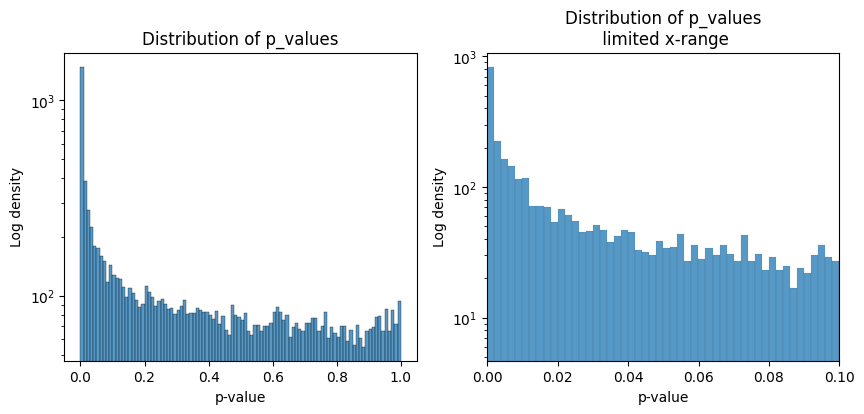

In [52]:
def plot_p_values(results):
    """
    Function to plot the distribution of p-values
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(x='p_value', data=results, bins=100, ax=ax[0])
    ax[0].set_yscale('log')
    ax[0].set_title('Distribution of p_values')
    ax[0].set_xlabel('p-value')
    ax[0].set_ylabel('Log density')
    
    sns.histplot(x='p_value', data=results, bins=500, ax=ax[1])
    ax[1].set_yscale('log')
    ax[1].set_xlim(0, 0.1)
    ax[1].set_title('Distribution of p_values\n limited x-range')
    ax[1].set_xlabel('p-value')
    ax[1].set_ylabel('Log density')

def gene_t_test(corhns, ulcerative, keys):   
    '''
    Function to scan the tables of gene expression for the two patient populations and perform gene wise t-tests.   

    Args: 
        crohns - data frame of gene responses for Corhn's disease patients with rows keyed by gene identifier. 
        ulcerative - data frame of gene responses for ulerative cholitis patients with rows keyed by gene identifier.
        keys - a list or array of gene key values as strings   
    Returns: 
        A data frame with gene identifier as row key and with the following columns:  
        t_statistic 
        p_value
    '''
    t_test = pd.DataFrame(columns = ['t_statistic', 'p_value', 'significant'], index = keys)
    for key in keys: 
        t_statistic, p_value = ttest_ind(corhns.loc[key,:], ulcerative.loc[key,:])
        t_test.loc[key,:] = [t_statistic, p_value, None]

    return t_test    


# Get a list of the key values
key_list = crohns.index

t_test_results = gene_t_test(crohns, ulcerative, key_list)
plot_p_values(t_test_results)

From these plots one can see that there are a large number small of p-values. This situation is likely to result in high false discovery rate.   

> **Exercise 1-06:** You will now apply the standard hypothesis test method with a fixed significance level and no false discovery rate control to the gene expression dataset, as a basis of comparison. To do so, you must complete the code for the `test_gene_significance` function. The function applies cutoff threshold or `significance_level` to the p-value and returns a logical, $\{True,False \}$. When you have completed the code execute it.  

In [53]:
def test_gene_significance(p_value, cutoff): 
    ## Put your code below 
   if p_value <= cutoff: return True
   else: return False

    

significance_level = 0.05 
for key in key_list:
    t_test_results.loc[key,'significant'] = test_gene_significance(t_test_results.loc[key,'p_value'], significance_level)

print(f"Number of significant tests: {sum(t_test_results.loc[:,'significant'])}")

Number of significant tests: 2548


> **End of exercise.**

### Bonferonni significance test on gene response

> **Exercise 1-07** With the basic test completed, you will now attempt to control the false discovery rate with the Bonforonni method. Execute the code in the cell below with the static cutoff value or `significance_level` computed using the cutoff value and number of tests.    

In [ ]:
cutoff = 0.05

## Put your code below
num_genes = len(key_list)
significance_level = cutoff / num_genes

for key in key_list:
    t_test_results.loc[key,'significant'] = test_gene_significance(t_test_results.loc[key,'p_value'], significance_level)

print(f"Bonferonni cutoff level for significance: {significance_level}")
print(f"Number of Bonferonni significant tests: {sum(t_test_results.loc[:,'significant'])}")

Bonferonni cutoff level for significance: 4.763265694960465e-06
Number of Bonferonni significant tests: 59


> Compare the results for the basic hypothesis test and Bonforonni correction and answer these questions:
> 1. Do you think it is likely the basic hypothesis test leads to a high false discovery rate and why?
> 2. Given the Bonferonni cutoff value do you think it is likely to lead to missed discoveries and why?
> 3. Do you think it would be easy to parallelize the algorithms used for the basic and Bonforonni corrected hypothesis tests and why?
>
> **End of exercise.** 

> **Answers:**
> 1. Yes, considering the high number of possible tests (10,497), it is likely we'll find false positive results by chance alone using the basic hypothesis test. With a cutoff of 0.05, we can expect around 525 false positive results by chance alone, and we have 2,548 significant results. We're not correcting for multiple comparisons, which is also why we can expect a high false discovery rate.      
> 2. Yes, we're likely to increase the Type II error rate (missed discoveries) using the Bonferroni correction, given how extremely conservative it is. We reduced the number of significant results from 2,548 to only 59, suggesting there may be many true biological signals that are being missed due to this very stringent correction.
> 3. Easily, both algorithms would be able to parallelize. For either of both we're running independent significance comparisons (only with different cutoffs) that can be easily computed in parallel across multiple processors and combined at the end. One result is completely independent from the other, which is why each processor can compute its assigned genes independently.       

## Improved False Discovery Rate Control Methods 

We have seen the potential pitfalls of multiple hypothesis testing. Further, we have seen that a simple Bonforonni approach to [**false discovery rate (FDR) control**](https://en.wikipedia.org/wiki/False_discovery_rate) is overly conservative may not be effective. You will now apply two more sophisticated FDR control methods, Holm's method and the Benjamini-Hochberg FDR control algorithm. These methods control the FDR, while not being overly conservative on true positive results, like the Bonferronic correction.        

These FDR control use the observation that p-values of the multiple hypothesis tests can be ordered. A dynamic threshold is applied to the ordered p-values to improve results compared to static methods like Bonforonni that use one threshold for all p-values. The dynamic threshold allows for both reduced false discovery rate while reducing the probability missed true discoveries.    

### Holm's method

The first of these **Holm's method**. Holm's method operates on the ordered set of p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$. The threshold is dynamic with the order of the P-value. For the $ith$ p-value, $p(i)$ for $N$ pairwise tests is:  

$$p(i) \le Threshold(Holm's) = \frac{\alpha}{N - i + 1}$$

For example: for the 10th ordered p-value with 1,000 total tests (genes) and significance level of 0.05, the cutoff is:   

$$p(10) \le \frac{0.05}{1000 - 10 + 1} = 0.00005045$$

> **Exercise 01-08:** You will now apply the dynamic Holm's FDR control method to the gene data. Do so by the following steps:
> 1. The table sorted by p-value in ascending order.     
> 2. An updated key list is created from the ordered table.
> 3. **Complete the code** to compute the Holm's significance levels by appending the cutoff values to the `significance_levels` list. Make sure you account for the zero-based indexing used in Python when computing the denominator.   
> 4. The significance tests are applied to the ordered p-values in the table.
> 5. The number of significant tests is computed and displayed.     

In [57]:
t_test_results.sort_values(by='p_value', ascending=True, inplace=True)
key_list = t_test_results.index

significance_level = 0.05 
significance_levels=[]

## Put your code below
N = len(key_list)
for i in range(len(key_list)):
    significance_levels.append(significance_level / (N - i + 1))


## The significance levels are added to the data frame 
t_test_results['significance_levels'] = significance_levels


for i, key in enumerate(key_list):
    t_test_results.loc[key,'significant'] = test_gene_significance(t_test_results.loc[key,'p_value'], significance_levels[i])

print(f"Number of Holm significant tests: {sum(t_test_results.loc[:,'significant'])}")

Number of Holm significant tests: 59


> With the results from the Holm's corrected significance test computed, execute the code in the cell below to display a graph summarizing these results.   

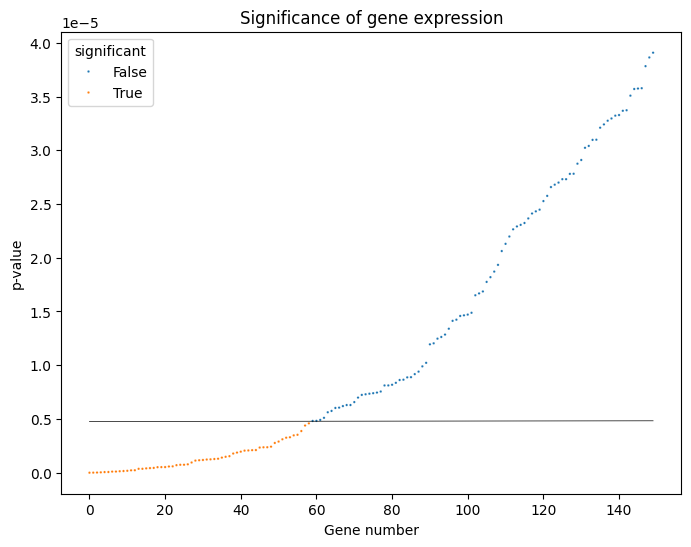

In [58]:
def plot_significance(results):
    results['test_number'] = range(len(results))
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x='test_number', y='significance_levels', data=results, ax=ax, color='black', linewidth=0.5)
    sns.scatterplot(x='test_number', y='p_value', hue='significant', data=results, s=3, ax=ax)
    ax.set_title('Significance of gene expression')
    ax.set_xlabel('Gene number')
    ax.set_ylabel('p-value')
    
plot_significance(t_test_results.iloc[:150,:].copy())    

> Compare the results of the Bonforonni correction to the Holm's method for the differences in gene expression between the two patient populations and answer these questions.
> 1. Compare the significant gene expressions found by the two methods.
> 2. Given the formulation of the Holm's method why are the cutoffs found to very dynamic for this specific situation?
>
> **End of exercise.** 

> **Answers:**
> 1. Both Bonferroni and Holm's methods found the same total of 59 significant results. This suggests that the most significant p-values are so small that they pass both thresholds, while the less significant p-values fail on both methods.          
> 2. The Holm's cutoffs are very dynamic because the thresholds are different depending on the position of the genes when we order them by p-value. So for the 1st gene in the ordered list (the smallest p-value), we're essentially using the Bonferroni cutoff (0.05 / 10497 - 1 + 1), while the cutoff is more lenient for the 1000th and even more for the 10000th gene in the ordered list, which allows for more discoveries. However, it is the case that in this particular dataset, both FDR control methods yield the exact same number of significant discoveries.

### Benjamini-Hochberg FDR Control 

The Benjamini-Hochberg FDR control algorithm is another way to control false discoveries. Stat with an ordered set of $n$ p-values, $D = \{ p_{(1)}, p_{(2)}, p_{(3)}, \ldots, p_{(n)} \}$ we define a false discovery rate, $q$:

$$FDR(D) \le q$$

The cutoff threshold for the ith p-value is then:
$$p_{(i)} \le Threshold(D_q) = \frac{q}{n} i$$

> **Exercise 01-09:** In this exercise you will apply the Benjamini-Hochberg FDR control algorithm for testing the significance of the gene expressions. The `BH_significance` function is quite similar to the Holm's method function you have already created. Given the large number of genes you must use a low false discovery rate, $q = 0.001$, or 1 out of 1,000. You will now proceed by the following steps:
> 1. **Complete the code** to compute the BH significance levels by appending the cutoff values to the `significance_levels` list. Make sure you account for the zero-based indexing used in Python when computing the denominator.   
> 2. The significance tests are applied to the ordered p-values in the table.
> 3. The number of significant tests is computed and displayed.
> 4. Display a plot summarizing the BH test results.
> 
> Execute the code.

Number of Benjamini-Hochberg significant tests: 71


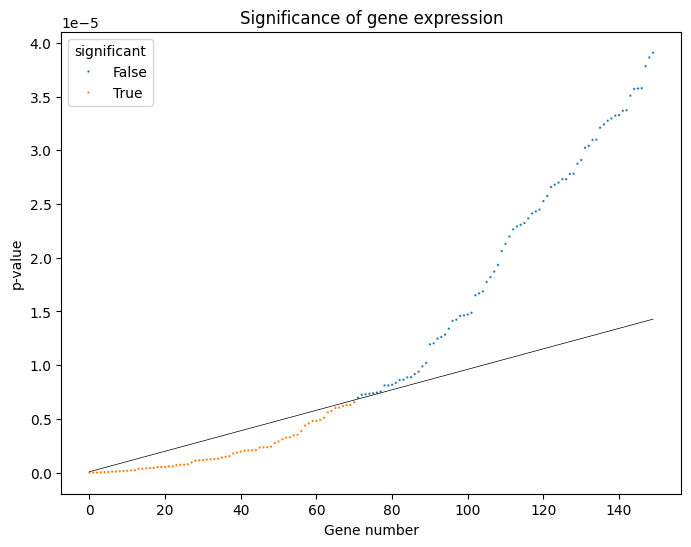

In [28]:
significance_level = 0.05 
q = 0.001
significance_levels=[]

## Put your code below  
N = len(key_list)
for i in range(len(key_list)):
    significance_levels.append(q * (i + 1) / N)



## Add the BH significance levels to the data frame
t_test_results['significance_levels'] = significance_levels


for i, key in enumerate(key_list):
    t_test_results.loc[key,'significant'] = test_gene_significance(t_test_results.loc[key,'p_value'], significance_levels[i])

print(f"Number of Benjamini-Hochberg significant tests: {sum(t_test_results.loc[:,'significant'])}")
plot_significance(t_test_results.iloc[:150,:].copy())  

> Compare the plots of results of the Benjamini-Hochberg FDR control method to those of Holm's method and answer the following questions.
> 1. Why does the Benjamini-Hochberg FDR control method give a more dynamic or adaptive result for the case where $i << n$?
> 2. The BH cutoff values have been computed allowing an expected false discovery rate of $ q \times N = 0.001 \times 10000 = 10$. What would be the effect of using a lower value of $q$ and why might this change not be a desirable?

> **Answers:**
> 1. The Benjamini-Hochberg FDR method creates a linear relationship between the position $i$ and the threshold, meaning that the rejection threshold scales with $i / n$. When $i << n$, then the threshold is very stringent, but as the number $i$ increases, the threshold adapts and allows more rejections (more significant hypothesis), which makes it sensitive to the actual proportion of discoveries in the data. This can be seen in our data by having more significant results allowed than the other two methods. 
> 2. If we lower $q$, we're making the Benjamini-Hochberg cutoff more stringent, which can lead to a reduced number of false positives, but we could also be sacrificing the discovery of true positives. This might not be desirable, as we can be throwing away genuine discoveries to reduce the false ones. 

**Note:** In practice, one should investigate using several values of $q$ for the BH FDR control algorithm to determine the effect of this parameter on the results. We will skip this step here in the interest of time.  

##### Copyright 2021, 2022, 2023, 2024, 2025 Stephen F. Elston. All rights reserved. 